In [871]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd

In [872]:
def plot_channels(data, time, channels, limit = None):
    figure, axes = plt.subplots(nrows = len(channels), figsize = (20, 0.75 * len(channels)))
    plt.subplots_adjust(
        left = 0.1,
        bottom = 0.1,
        right = 0.9,
        top = 0.9,
        wspace = 0,
        hspace = 0
    )

    x = time

    for i, channel in enumerate(channels):
        y = data[ :, i ]
        axes[ i ].plot(x, y, linewidth = 0.5, color = 'black')

        if limit is not None:
            axes[ i ].set_ylim(-limit, limit)

        axes[ i ].set_xlim(0, 10)
        axes[ i ].get_xaxis().set_ticks([ ])
        axes[ i ].get_yaxis().set_ticks([ ])
        axes[ i ].set_ylabel(channel, rotation = 0, labelpad = 60, loc = 'center')

        if i != 0:
            axes[ i ].spines[ 'top' ].set_visible(False)

        if i != len(channels) - 1:
            axes[ i ].spines[ 'bottom' ].set_visible(False)

    plt.show()

In [873]:
with open('raw/W1_C1_EMG_rest.txt', 'r') as file:
    data = np.array(list(csv.reader(file, delimiter = '\t')))

channels = list(data[ 0, : ])
data = data[ 1:, : ].transpose()
sfreq = 20000.0  # Hz

ch_types = [ 'emg' for i in range(0, len(channels)) ]

info = mne.create_info(ch_names = channels, sfreq = sfreq, ch_types = ch_types)
raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=30, n_times=200001
    Range : 0 ... 200000 =      0.000 ...    10.000 secs
Ready.


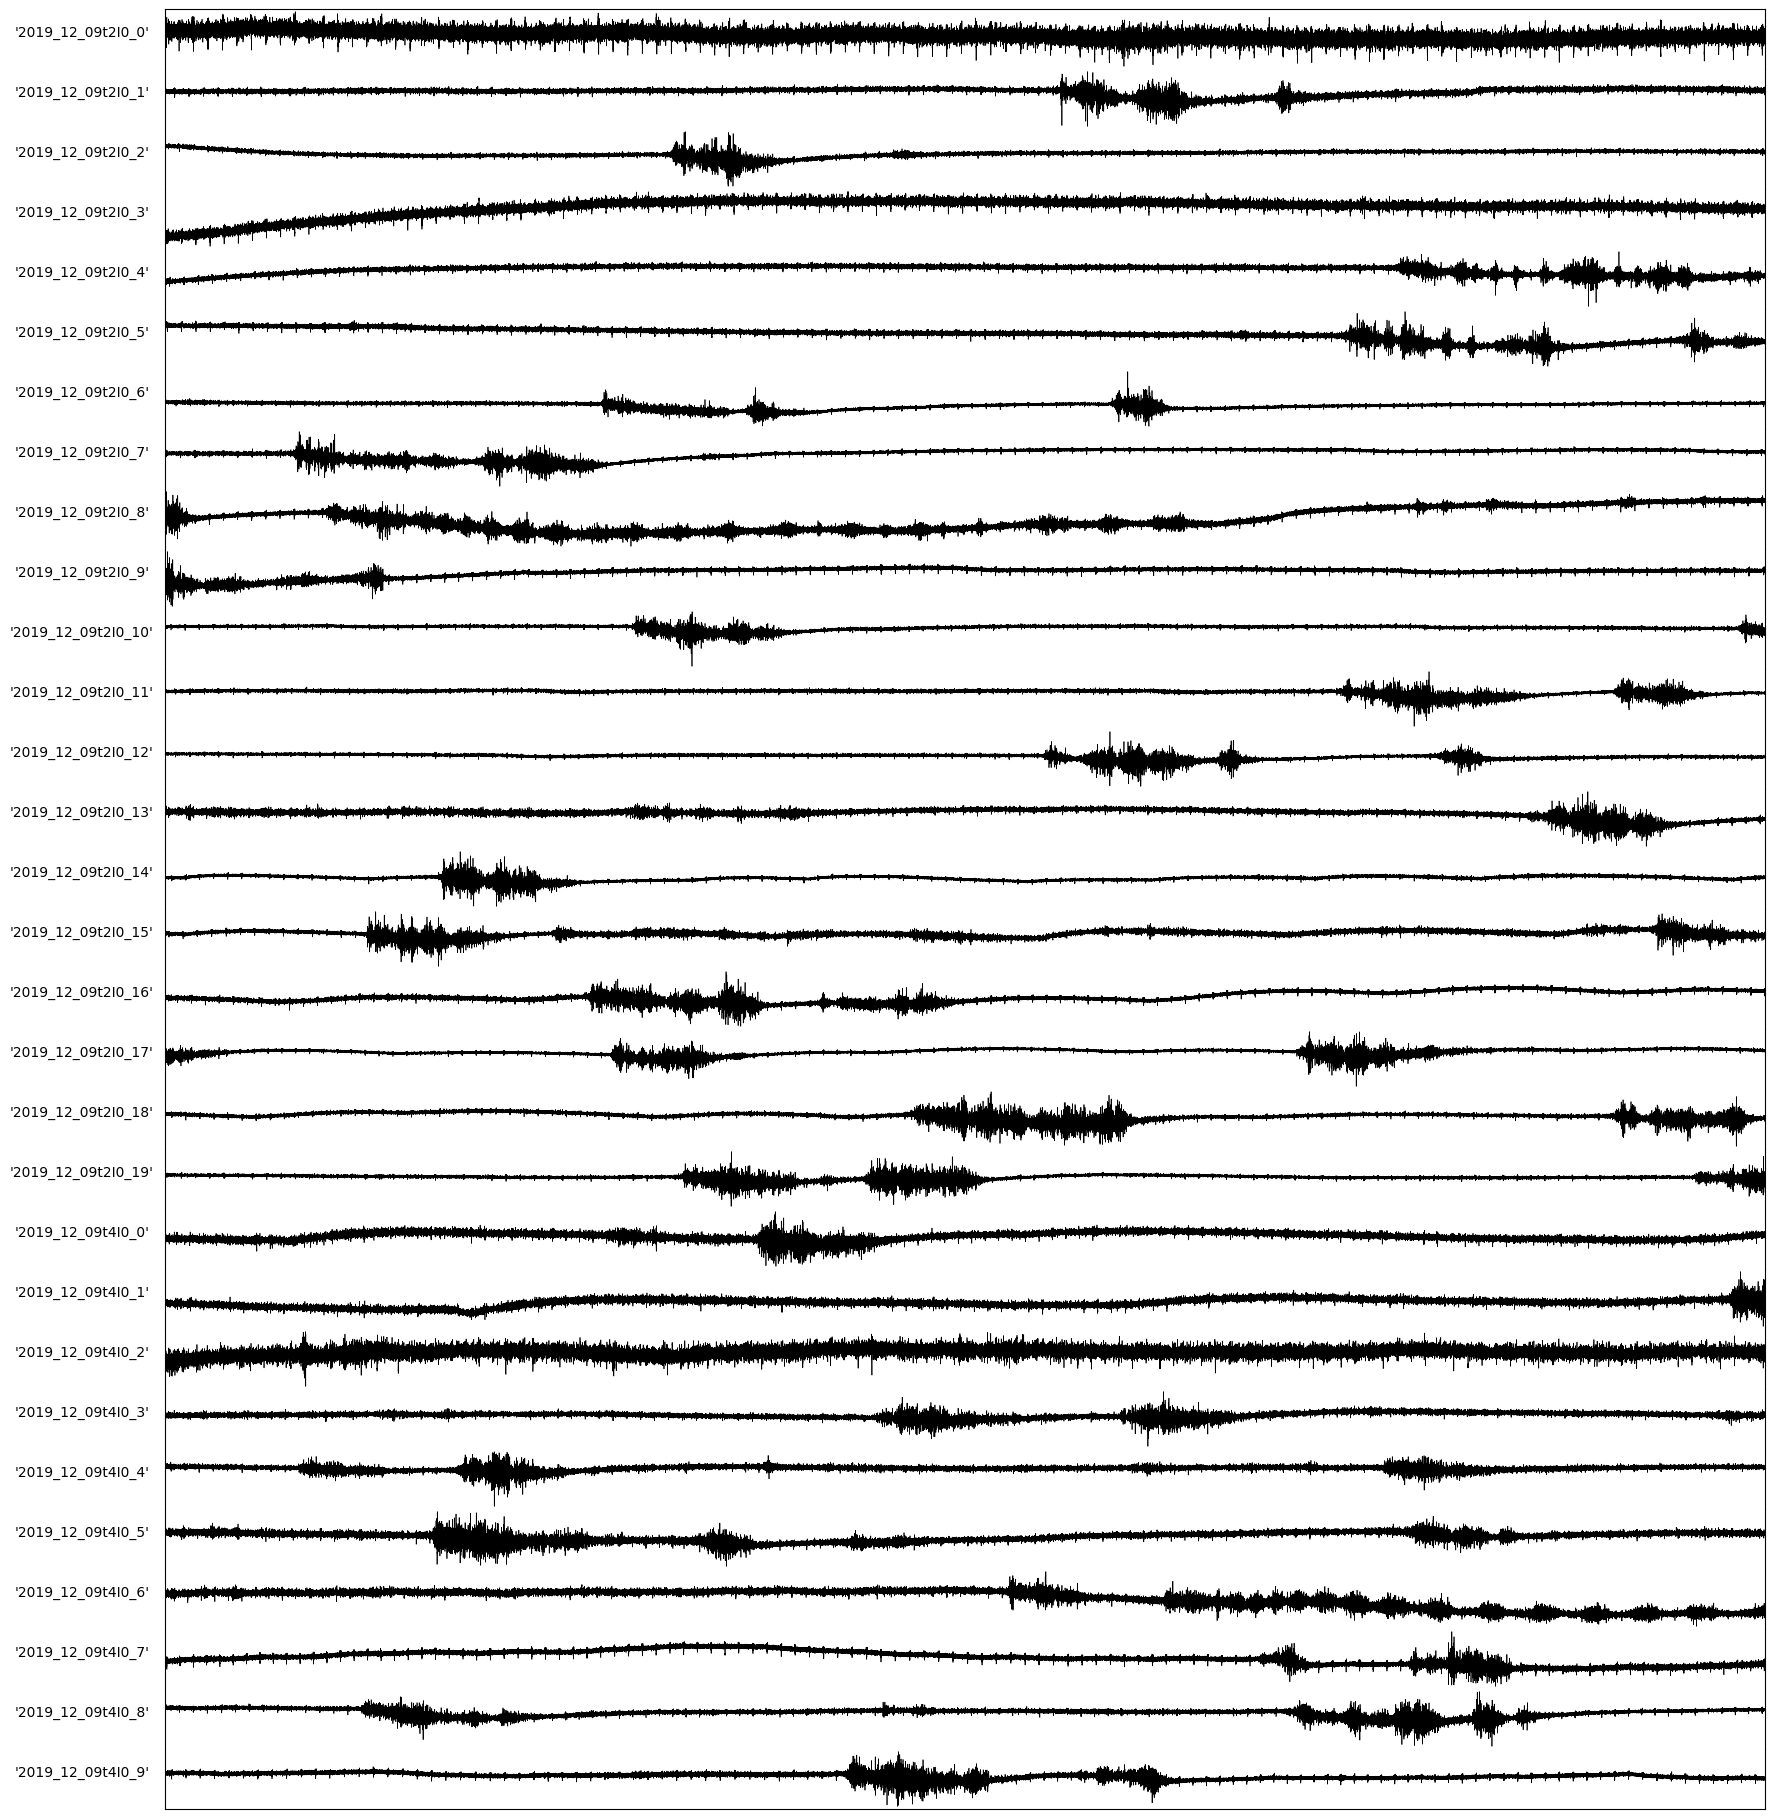

In [874]:
plot_channels(data = raw.get_data().T, time = raw.times, channels = channels, limit = None)

Effective window size : 0.102 (s)


/var/folders/qt/hgl1dlf168d7h94jf7mz7b3c0000gn/T/ipykernel_90798/1935271028.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(picks = 'emg').plot(picks = 'emg')
/Users/ieva/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


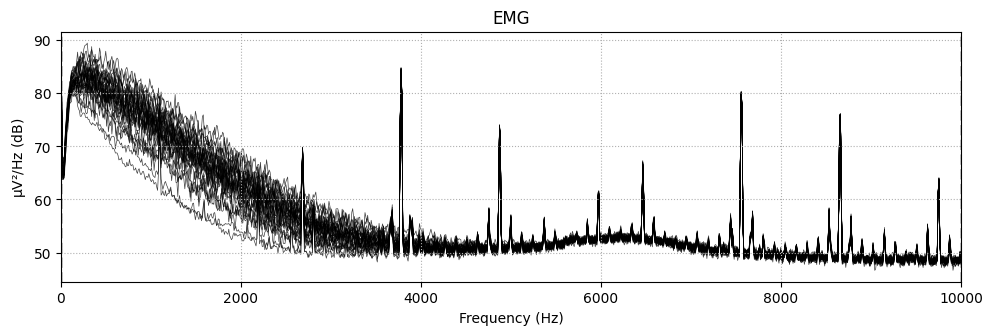

In [875]:
# Periodogram
raw.compute_psd(picks = 'emg').plot(picks = 'emg')
plt.show()

In [876]:
raw.filter(l_freq = 20, h_freq = None, fir_design = 'firwin', picks = 'emg')

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Filter length: 13201 samples (0.660 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


<RawArray | 30 x 200001 (10.0 s), ~45.8 MB, data loaded>

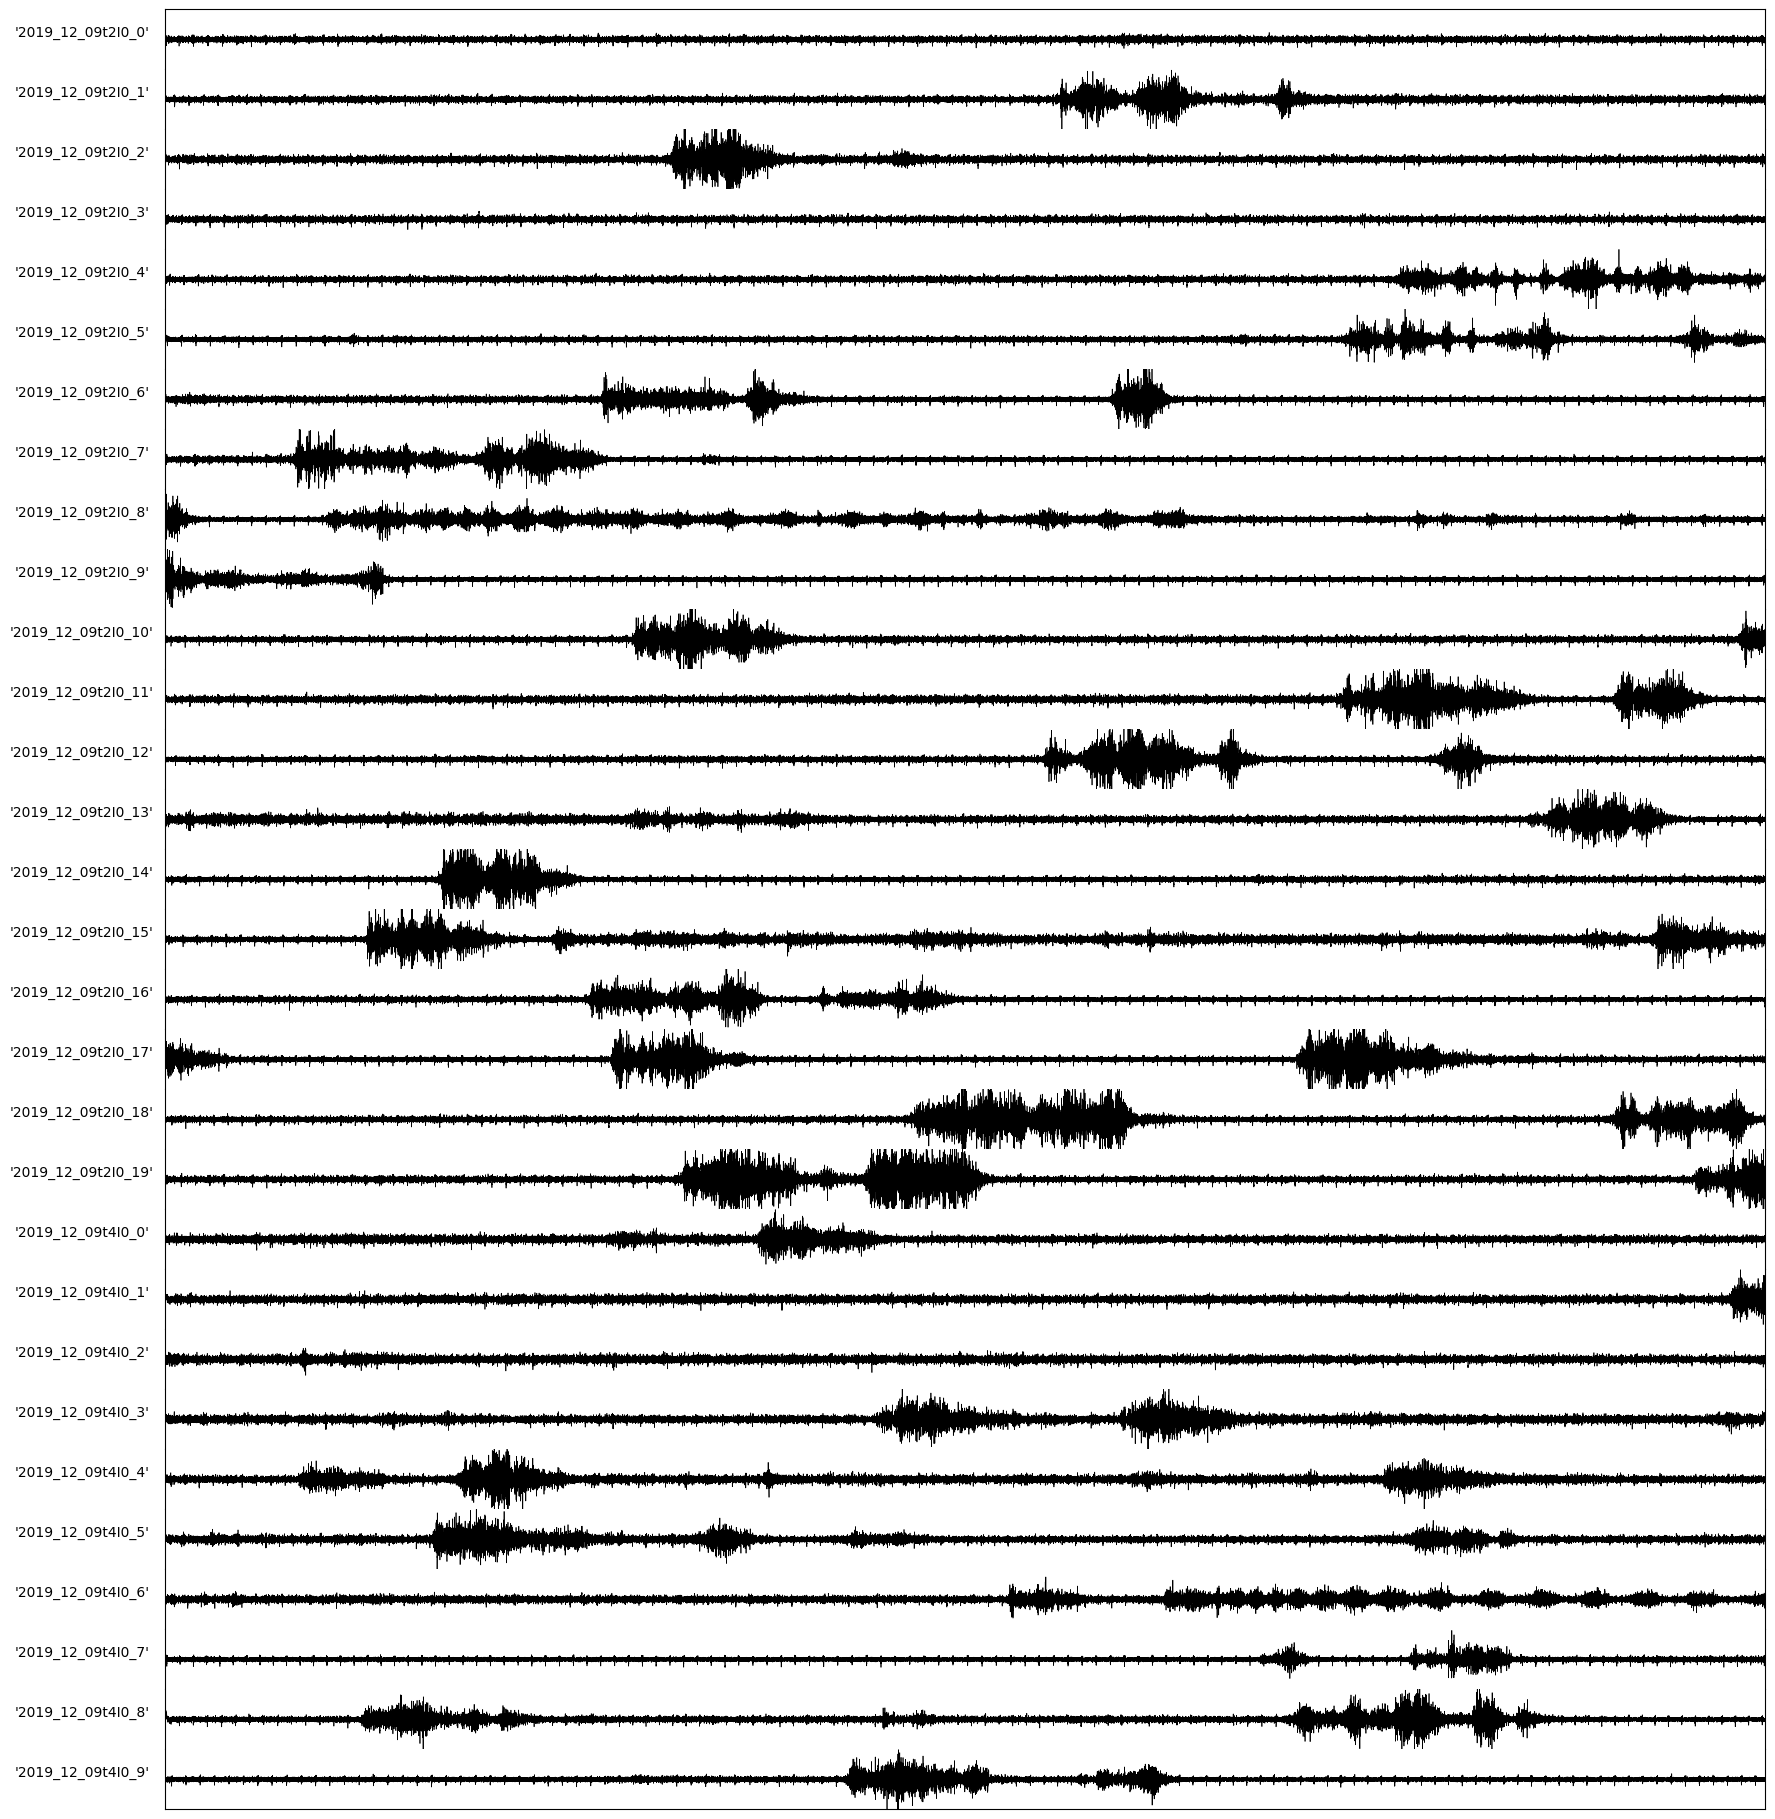

In [877]:
plot_channels(data = raw.get_data().T, time = raw.times, channels = channels, limit = 4)

Effective window size : 0.102 (s)


/var/folders/qt/hgl1dlf168d7h94jf7mz7b3c0000gn/T/ipykernel_90798/1248457558.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(picks = channels[ 0 ]).plot(picks = channels[ 0 ])
/Users/ieva/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


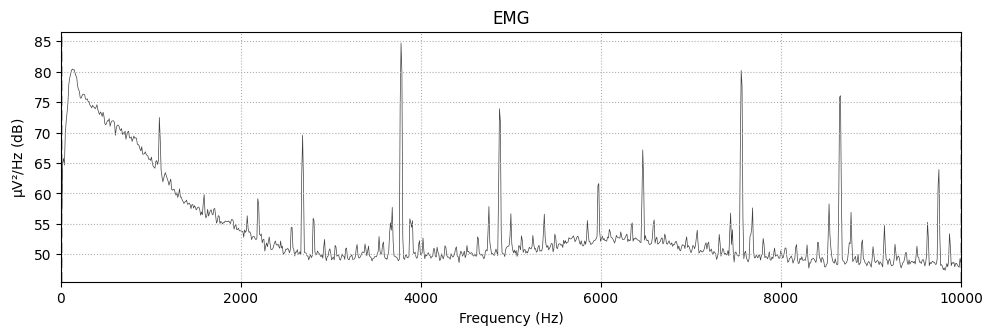

In [878]:
# Periodogram
raw.compute_psd(picks = channels[ 0 ]).plot(picks = channels[ 0 ])
plt.show()

In [879]:
# Tried ICA, but it did not manage to filter out the heartbeat.

# Questions:
# 1. Experimental design -- what exactly was done with these mice? Is EMG recorded from one cell as well? Do the EMG channels correspond somehow to Vm recordings?
# 2. Data filtering (low = 20 Hz, high = None)
# 3. What is considered movement? Is it those bursts of high amplitude signals? Do we consider it movement when there is "movement" in at least one channel?

## Teager-Kaiser Energy Operator

The Teager-Kaiser Energy Operator (TKEO) is used to improve the signal quality for onset movement detection. The formula for calculating the TKEO for any signal is as follows:

$$\Psi[x(n)] = x^2(n) - x(n + 1) \times x(n - 1)$$

In [880]:
def tkeo(signal):
    return signal[ 1:-1 ] ** 2 - signal[ :-2 ] * signal[ 2: ]

In [881]:
signal = raw.get_data(picks = [ 1 ])[ 0 ]

tke = tkeo(signal)
t = raw.times

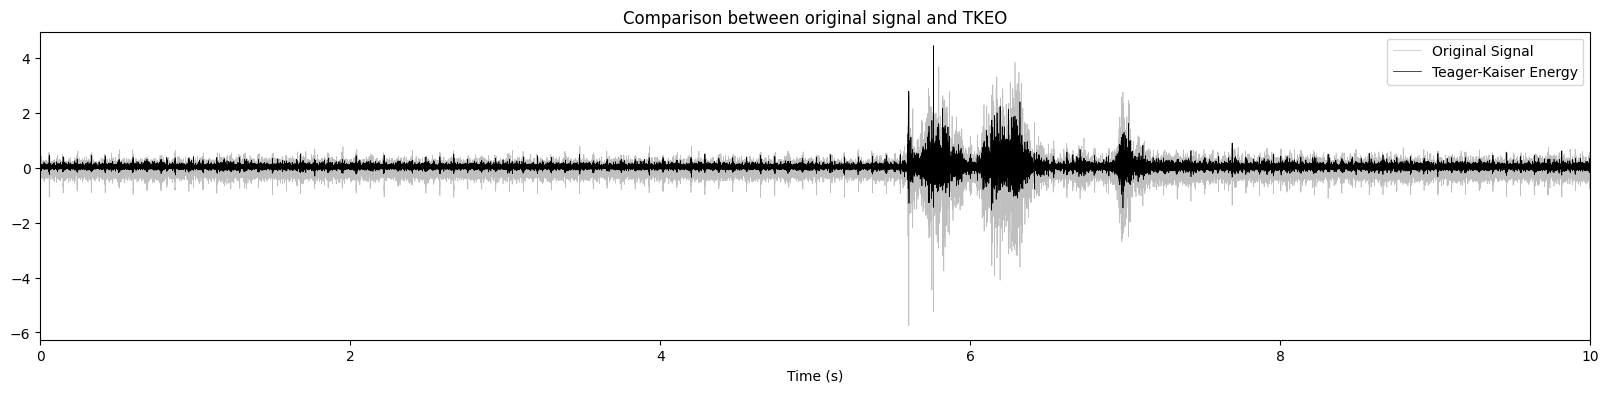

In [882]:
plt.figure(figsize = (20, 4))
plt.plot(t, signal, label = 'Original Signal', linewidth = 0.5, color = 'gray', alpha = 0.5)
plt.plot(t[ 1:-1 ], tke, label = 'Teager-Kaiser Energy', linewidth = 0.5, color = 'black')
plt.xlim(0, 10)
plt.xlabel('Time (s)')
plt.legend()
plt.title('Comparison between original signal and TKEO')
plt.show()

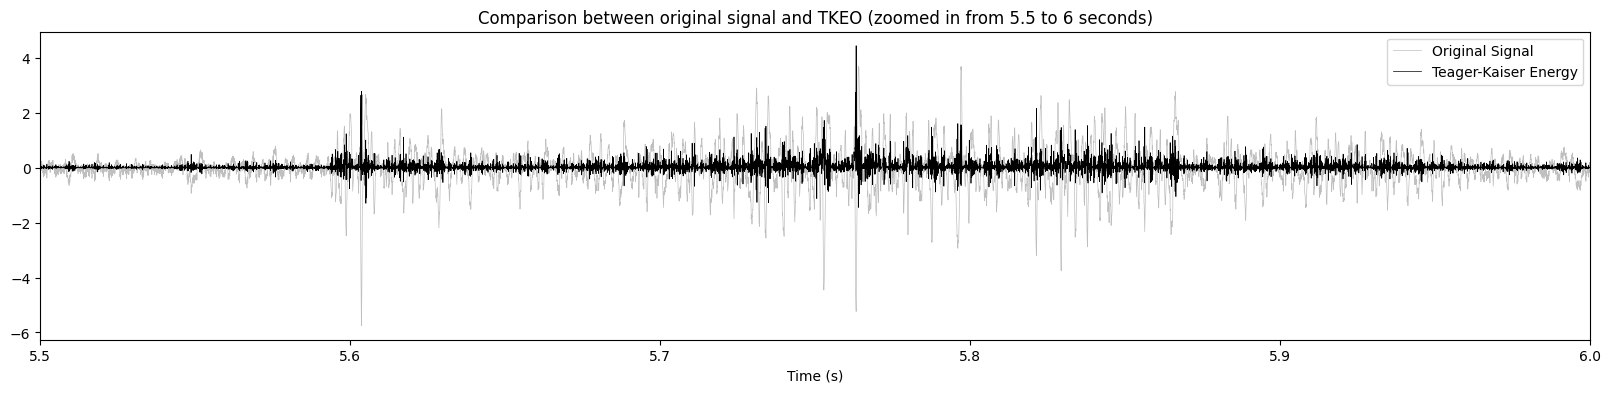

In [883]:
plt.figure(figsize = (20, 4))
plt.plot(t, signal, label = 'Original Signal', linewidth = 0.5, color = 'gray', alpha = 0.5)
plt.plot(t[ 1:-1 ], tke, label = 'Teager-Kaiser Energy', linewidth = 0.5, color = 'black')
plt.xlim(5.5, 6)
plt.xlabel('Time (s)')
plt.legend()
plt.title('Comparison between original signal and TKEO (zoomed in from 5.5 to 6 seconds)')
plt.show()

In [884]:
tke = [ ]

for i, channel in enumerate(channels):
    signal = raw.get_data(picks = channel)[ 0 ]
    tke.append(tkeo(signal))

tke = np.array(tke).transpose()

ch_types = [ 'emg' for i in range(0, len(channels)) ]
info = mne.create_info(ch_names = channels, sfreq = sfreq, ch_types = ch_types)
tke = mne.io.RawArray(tke.T, info)

Creating RawArray with float64 data, n_channels=30, n_times=199999
    Range : 0 ... 199998 =      0.000 ...    10.000 secs
Ready.


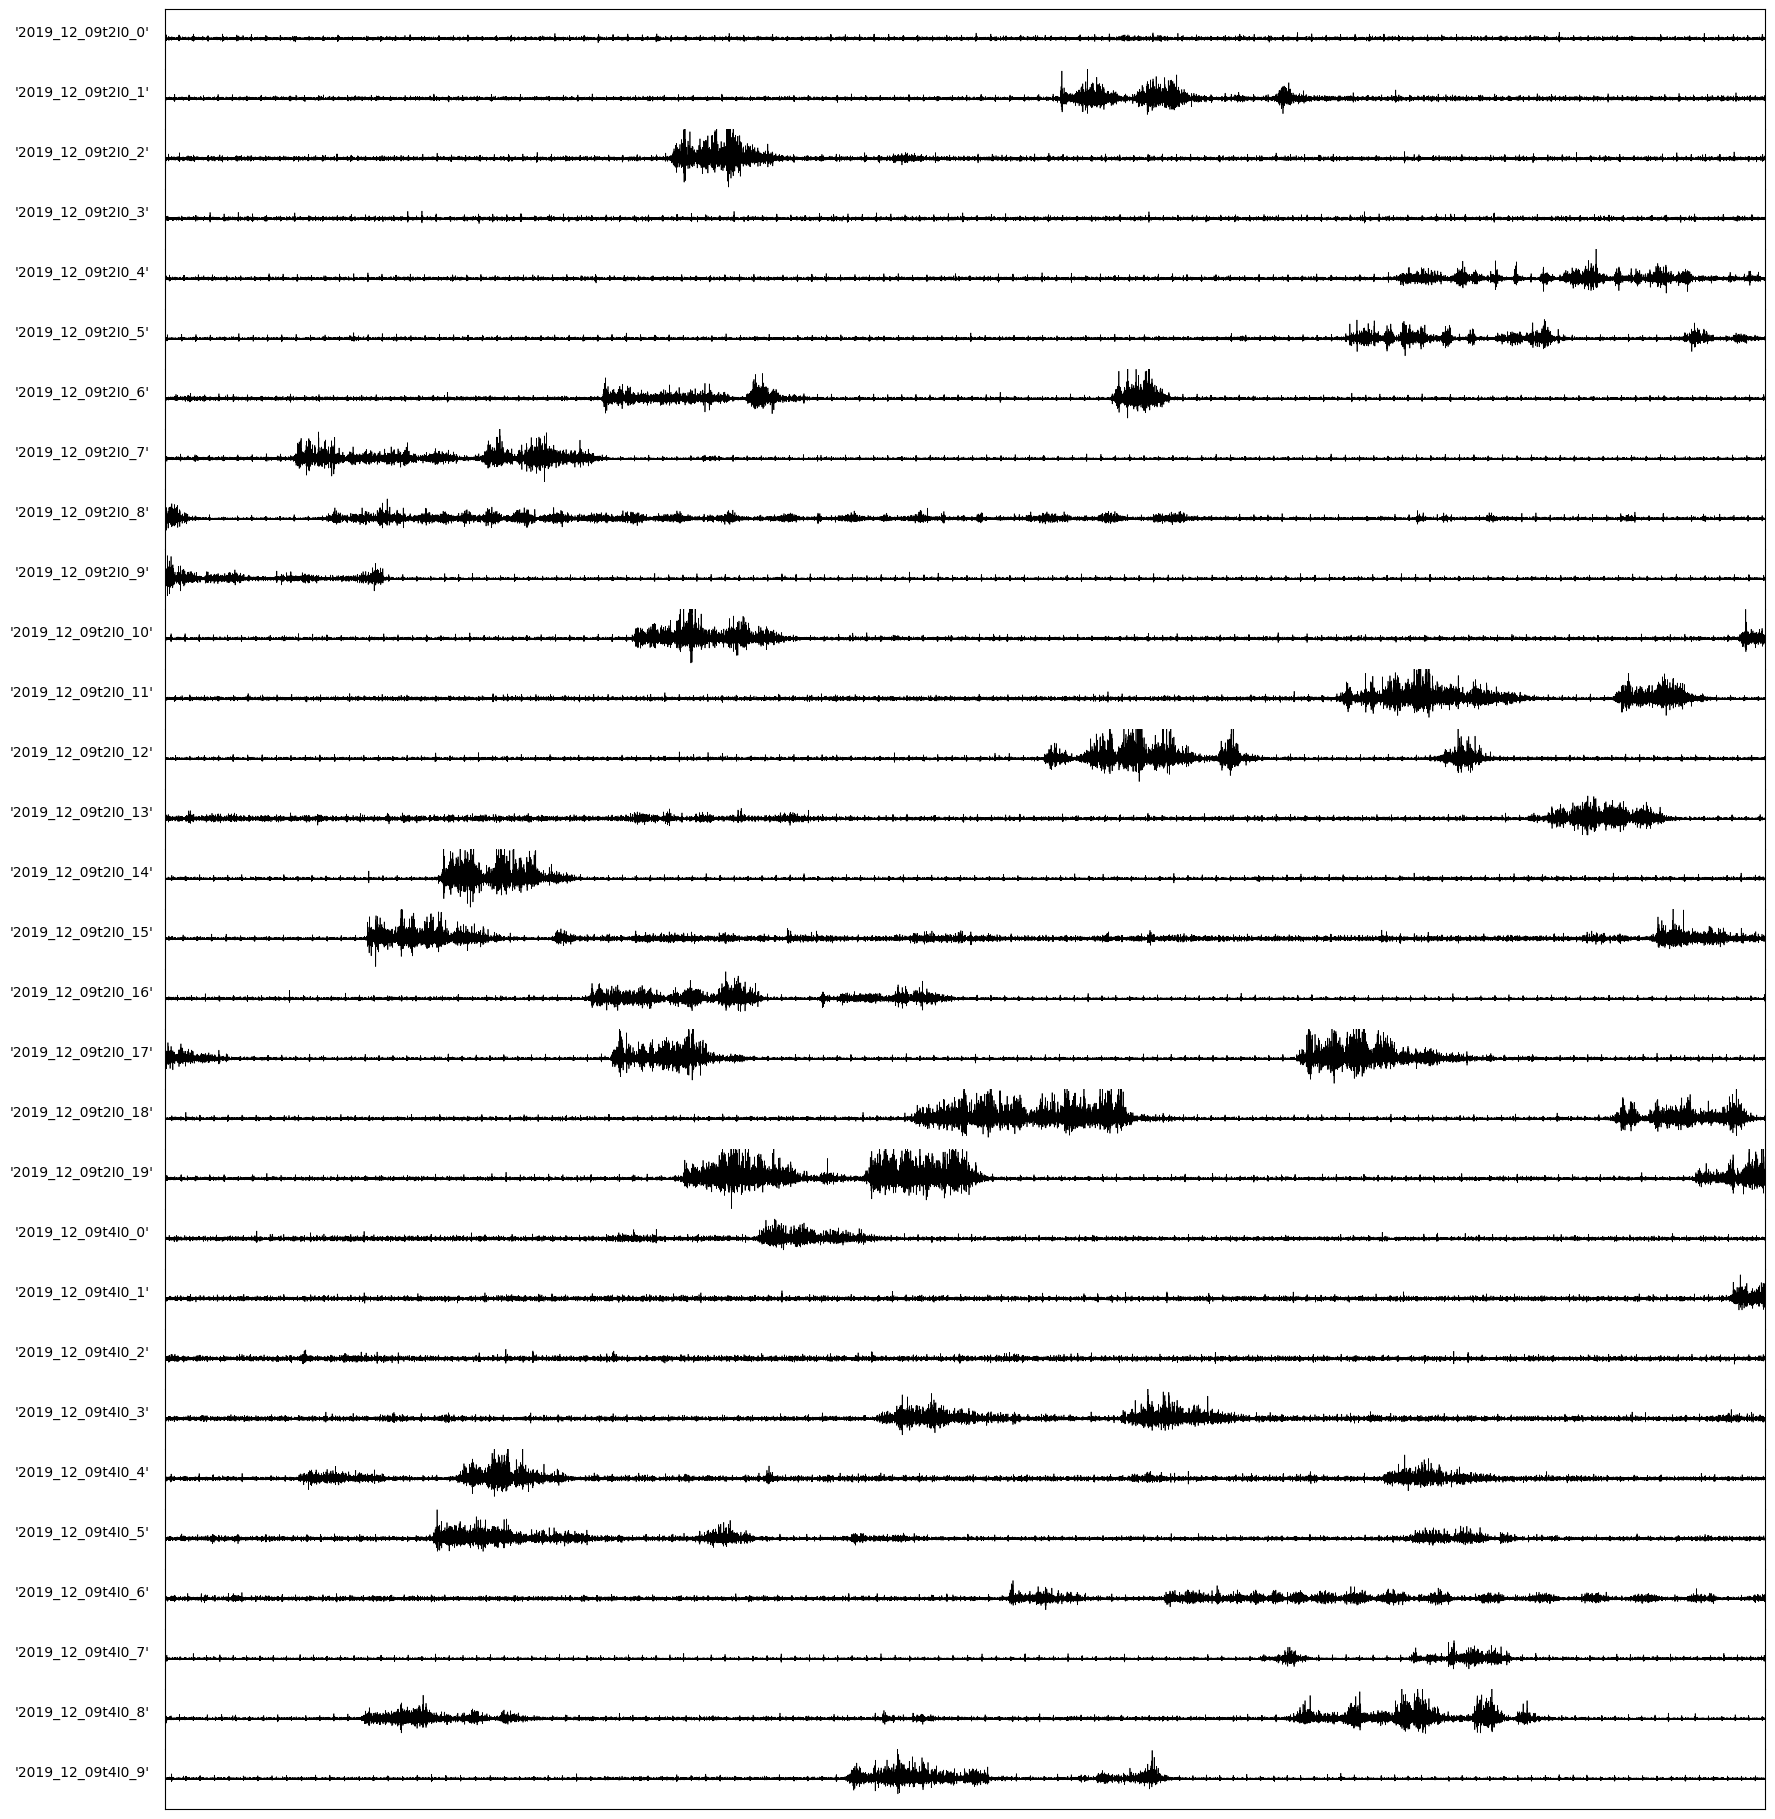

In [885]:
plot_channels(data = tke.get_data().T, time = tke.times, channels = channels, limit = 3)

Effective window size : 0.102 (s)


/var/folders/qt/hgl1dlf168d7h94jf7mz7b3c0000gn/T/ipykernel_90798/525161481.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  tke.compute_psd(picks = 'emg').plot(picks = 'emg')
/Users/ieva/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


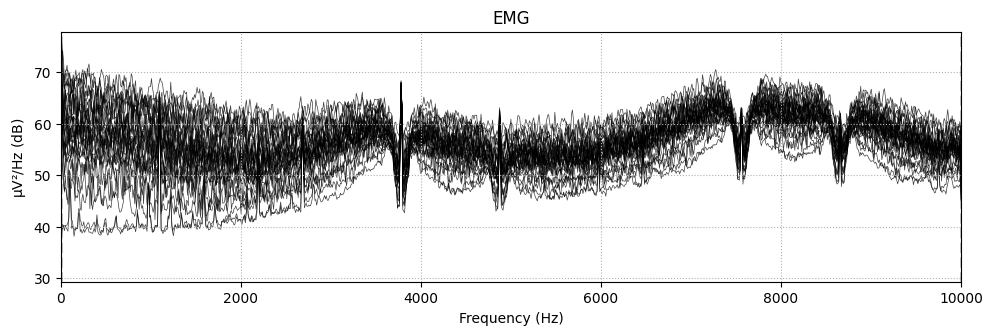

In [886]:
tke.compute_psd(picks = 'emg').plot(picks = 'emg')
plt.show()

In [887]:
tke.filter(l_freq = None, h_freq = 10, fir_design = 'firwin', picks = 'emg')

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 26401 samples (1.320 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


<RawArray | 30 x 199999 (10.0 s), ~45.8 MB, data loaded>

Effective window size : 0.102 (s)


/var/folders/qt/hgl1dlf168d7h94jf7mz7b3c0000gn/T/ipykernel_90798/525161481.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  tke.compute_psd(picks = 'emg').plot(picks = 'emg')
/Users/ieva/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


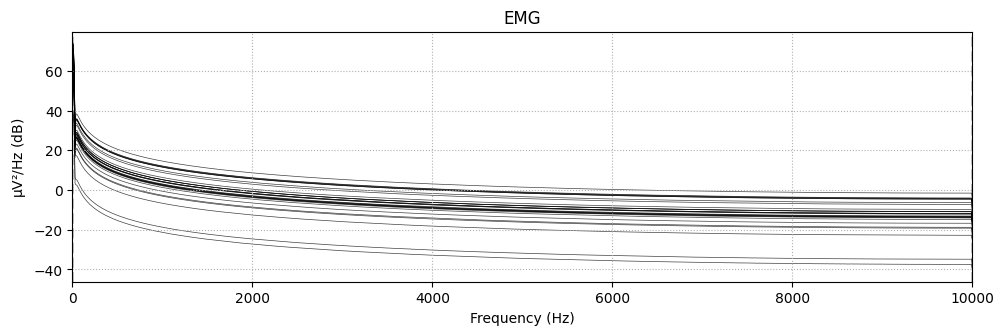

In [888]:
tke.compute_psd(picks = 'emg').plot(picks = 'emg')
plt.show()

In [889]:
def normalize(a, b, data):
    data_range = np.max(np.abs(data))
    return (b - a) * (data + data_range) / (2 * data_range) + a

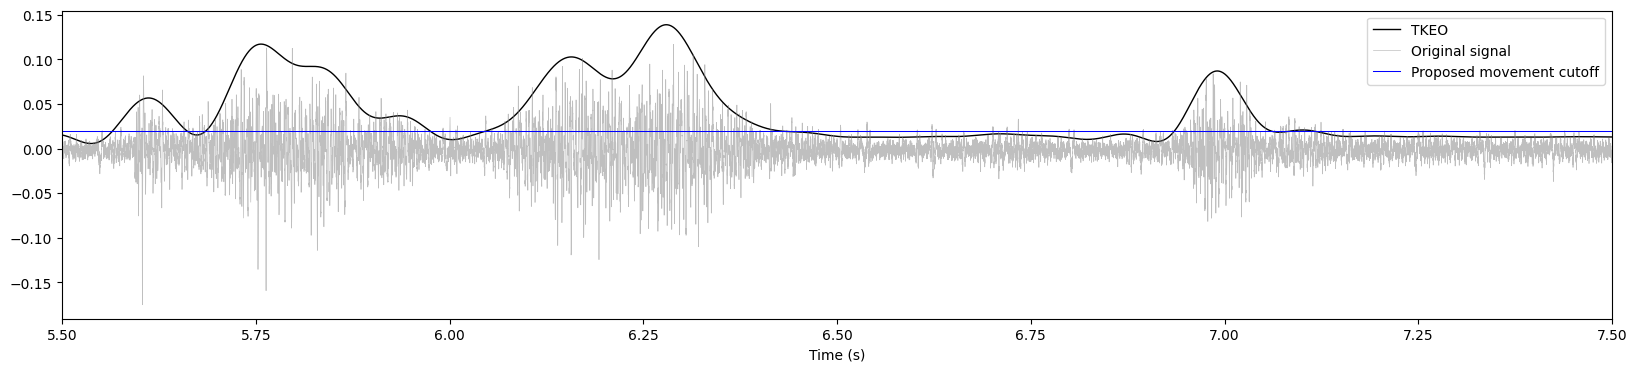

In [890]:
tke_signal = tke.get_data(picks = [ 1 ])[ 0 ]
tke_time = tke.times

signal = raw.get_data(picks = [ 1 ])[ 0 ]
normalized_signal = normalize(-0.175, 0.175, signal)
signal_time = raw.times

plt.figure(figsize = (20, 4))
plt.plot(tke_time, tke_signal, linewidth = 1, color = 'black', label = 'TKEO')
plt.plot(signal_time, normalized_signal, linewidth = 0.5, color = 'gray', alpha = 0.5, label = 'Original signal')
plt.xlabel('Time (s)')
plt.xlim(5.5, 7.5)
plt.axhline(y = 0.02, color = 'blue', linestyle = '-', linewidth = 0.75, label = 'Proposed movement cutoff')
plt.legend()
plt.show()

In [891]:
def merge_short(data, min_break = 200):
    i = 1
    while i < data.shape[0] - 1:
        if data.iloc[ i ][ 'Length' ] >= min_break:
            i = i + 1
            continue

        previous_el = data.iloc[ i - 1 ]
        next_el = data.iloc[ i + 1 ]
        current = data.iloc[ i ]

        data.at[ i, 'Length' ] = previous_el[ 'Length' ] + next_el[ 'Length' ] + current['Length']
        data.at[ i, 'EventStart' ] = previous_el[ 'EventStart' ]
        data.at[ i, 'EventEnd' ] = next_el[ 'EventEnd' ]
        data.at[ i, 'Movement' ] = previous_el[ 'Movement' ]

        data = data.drop(i - 1)
        data = data.drop(i + 1)
        data = data.reset_index(drop = True)

    return data


def extract_events(signal, sampling_rate, threshold = 0.02, min_event_length = 0.1, min_break = 200):
    min_points = sampling_rate * min_event_length  # The minimum number of consecutive points for movement detection

    signal_over_threshold = signal >= threshold
    change_indices = np.where(np.diff(signal_over_threshold))[ 0 ]

    movement_data = pd.DataFrame({
        'EventStart': change_indices[ :-1 ],
        'EventEnd': change_indices[ 1: ],
        'Movement': signal_over_threshold[ change_indices[ :-1 ] + 1 ]
    })

    movement_data[ 'Length' ] = movement_data.apply(lambda row: row.EventEnd - row.EventStart, axis = 1)
    movement_data = merge_short(movement_data, min_break = min_break)
    movement_data = movement_data[ movement_data[ 'Length' ] >= min_points ]
    movement_data = movement_data[ movement_data[ 'Movement' ] == True ]

    return movement_data

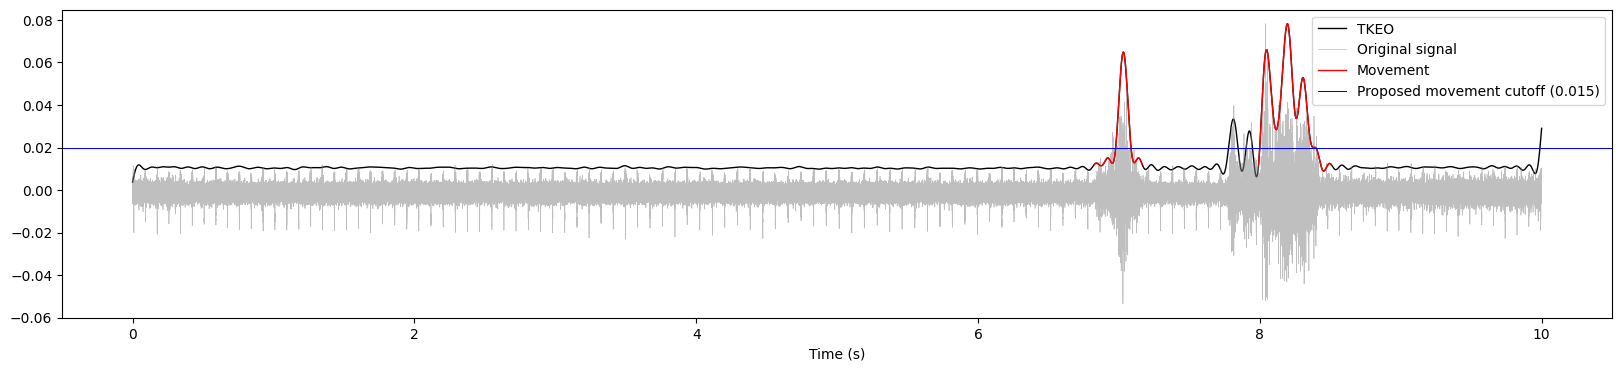

In [892]:
channel_i = -3

tke_signal = tke.get_data(picks = [ channel_i ])[ 0 ]
tke_time = tke.times

move_events = extract_events(tke_signal, sampling_rate = sfreq, threshold = 0.012, min_event_length = 0.1, min_break = 2000)

signal = raw.get_data(picks = [ channel_i ])[ 0 ]

tke_range = np.max(np.abs(tke_signal))
normalized_signal = normalize(-tke_range, tke_range, signal)
signal_time = raw.times

plt.figure(figsize = (20, 4))
plt.plot(tke_time, tke_signal, linewidth = 1, color = 'black', label = 'TKEO')
plt.plot(signal_time, normalized_signal, linewidth = 0.5, color = 'gray', alpha = 0.5, label = 'Original signal')

has_label = False
for index, row in move_events.iterrows():
    start = row[ 'EventStart' ]
    end = row[ 'EventEnd' ]

    if has_label:
        plt.plot(tke_time[ start:end ], tke_signal[ start:end ], linewidth = 1, color = 'red')
    else:
        has_label = True
        plt.plot(tke_time[ start:end ], tke_signal[ start:end ], linewidth = 1, color = 'red', label = 'Movement')

# plt.xlim(5.5, 7.5)
plt.xlabel('Time (s)')
plt.axhline(y = 0.02, color = 'blue', linestyle = '-', linewidth = 0.75, label = 'Proposed movement cutoff (0.015)')
plt.legend()
plt.show()

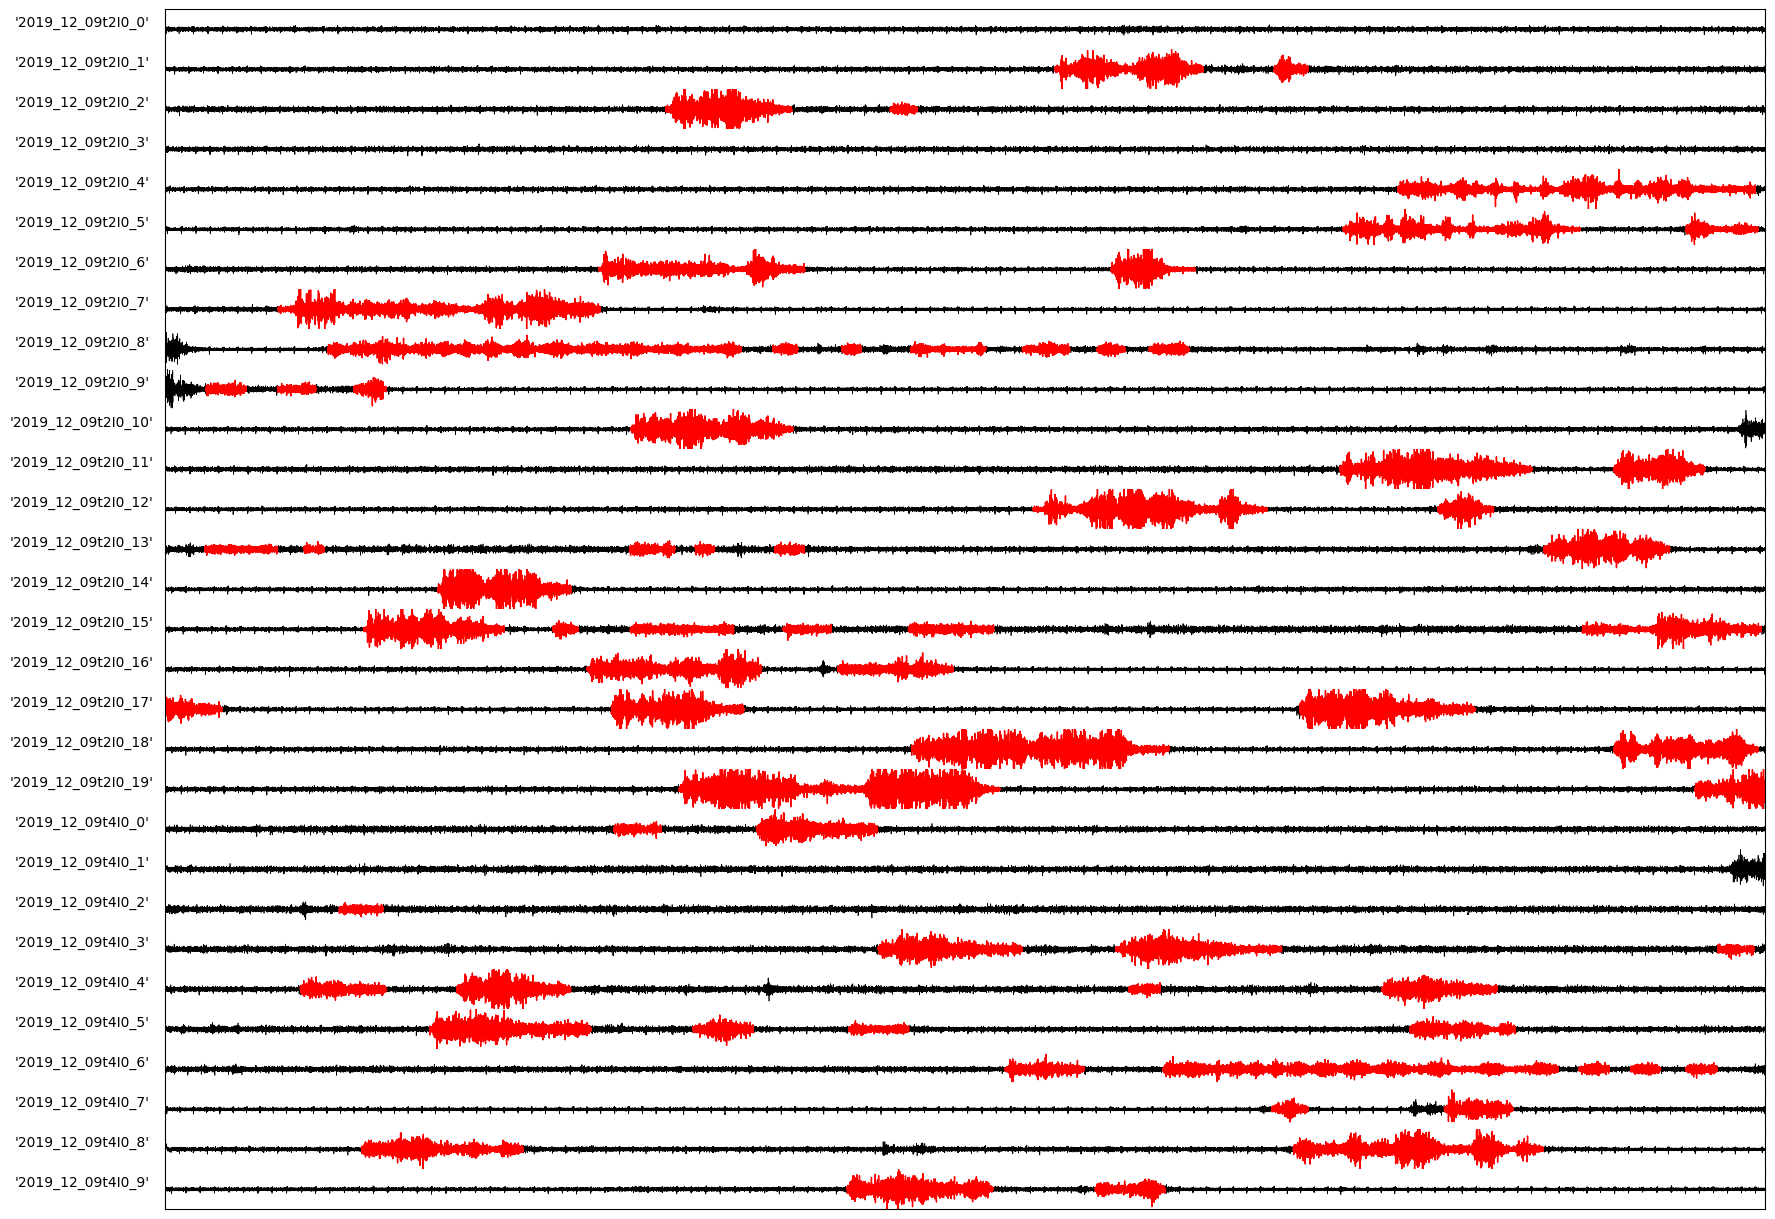

In [893]:
figure, axes = plt.subplots(nrows = len(channels), figsize = (20, 0.5 * len(channels)))
plt.subplots_adjust(
    left = 0.1,
    bottom = 0.1,
    right = 0.9,
    top = 0.9,
    wspace = 0,
    hspace = 0
)

x = raw.times

has_label = False

for i, channel in enumerate(channels):
    tke_signal = tke.get_data(picks = [ i ])[ 0 ]
    tke_time = tke.times

    move_events = extract_events(tke_signal, sampling_rate = sfreq, threshold = 0.015, min_event_length = 0.1, min_break = 2000)

    y = raw.get_data(picks = [ i ])[ 0 ]

    axes[ i ].plot(x, y, linewidth = 0.5, color = 'black')
    axes[ i ].set_ylim(-4, 4)
    axes[ i ].get_xaxis().set_ticks([ ])
    axes[ i ].get_yaxis().set_ticks([ ])
    axes[ i ].set_ylabel(channel, rotation = 0, labelpad = 60, loc = 'center')
    axes[ i ].set_xlim(0, 10)

    for index, row in move_events.iterrows():
        start = row[ 'EventStart' ]
        end = row[ 'EventEnd' ]

        if has_label:
            axes[ i ].plot(x[ start:end ], y[ start:end ], linewidth = 1, color = 'red')
        else:
            has_label = True
            axes[ i ].plot(x[ start:end ], y[ start:end ], linewidth = 1, color = 'red', label = 'Movement')

    if i != 0:
        axes[ i ].spines[ 'top' ].set_visible(False)

    if i != len(channels) - 1:
        axes[ i ].spines[ 'bottom' ].set_visible(False)

plt.show()

In this step, the movement detection algorithm is more sensitive. The results will be filtered out later on to keep only good quality recordings.